# Метод главных компонент: аналитическое решение

В этой статье мы залезем под капот одному из линейных способов понижения размерности признакового пространства данных, а именно, подробно ознакомимся с математической стороной метода главных компонент (Principal Components Analysis, PCA).

***Содержание статьи:***

*Примечания автора*

***Вместо введения***

***1) Значение принципа максимизации дисперсии в методе главных компонент***

*1.1) Принцип максимизации дисперсии*

*1.2) Синтетический пример: метод главных компонент в действии*

***2) Под капотом метода главных компонент***

*2.1) Преобразование матрицы признакового пространства $X$ в матрицу компонент $Z$ путем умножения первой на матрицу $W$:*

$$ \begin{equation*}
 \begin{cases}
   XW = Z
   \\
   W^TW = I
 \end{cases}
\end{equation*} $$

*2.2) Связка преобразования признакового пространства с принципом максимизации дисперсии через ковариационную матрицу $\Lambda_Z$:*

$$ \begin{equation*}
 \begin{cases}
   W^TX^TXW = \Lambda_Z
   \\
   W^TW = I
 \end{cases}
\end{equation*} $$

*2.3) Метод множителей Лагранжа: приведение уравнения $W^TX^TXW = \Lambda_Z$ с условием того, что $W^TW = I$ к виду:*

$$ L=\vec{w_j^T}X^TX\vec{w_j} - \lambda_j(\vec{w_j^T}\vec{w_j}-1) $$

*2.4) Переход от задачи  дифференцирования функции Лагранжа по вектору $\vec{w_j}$ к задаче поиска собственных значений $ \lambda_j $ и собственных векторов $\vec{w_j}$ матрицы $X^TX$:*

$$ \frac{d(L)}{d(w_j)} = \frac{d(\vec{w_j^T}X^TX\vec{w_j} - \lambda_j(\vec{w_j^T}\vec{w_j}-1))}{d(w_j)}
\mkern 15mu \Longrightarrow \mkern 15mu X^T X \vec{w_j} = \lambda_j \vec{w_j} $$

*2.5) Аналитическое решение: поиск собственных значений и собственных векторов матрицы $X^TX$*

***Вместо заключения***

## Примечания автора

Данная статья, как и большинство моих предыдущих работ, не пропитана глубокой теорией, скорее наоборот - строгие теоретические выкладки здесь приводятся по минимуму. Вместо формального подхода к описанию метода главных компонент, рассмотрим один синтетический пример, разобрав который, мы сможем лучше понять механизм действия метода.

- В первой части статьи мы посмотрим на то, что происходит с данными после их преобразования методом главных компонент. Изучать преобразования мы будем на простом примере. 

- Во второй части мы рассмотрим ответы на вопросы, связанные с тем, как происходят эти преобразования, то есть рассмотрим математику процесса.

Весь код в статье написан на языке *python 3*.

Для лучшего усвоения материала, читателю следует разбираться в основах аналитической геометрии, уметь перемножать матрицы и находить их определители, решать системы линейных уравнений с несколькими неизвестными, находить частные производные от матричных выражений, понимать суть основных характеристик случайных величин (математическое ожидание, вариация, ковариация, корреляция) и безусловно, читателю необходимо иметь хорошее представление об основных моделях машинного обучения. Это минимальный набор знаний, с которым стоит подойти к изучению статьи, остальные знания мы получим в процессе.

## Вместо введения

Перед тем как перейти к первой части статьи, давайте определим основные цели понижения размерности признакового пространства. В самом общем виде, исследователь понижает размерность исходных данных в следующих случаях:

Во-первых, вследствие того, что признаков настолько много, что вычисления происходят значительно дольше требуемого времени. Например, в интернет-магазине требуется в считаные доли секунд предложить потенциальному покупателю рекомендацию. В этой ситуации, признаков на основании которых может быть дана рекомендация очень много и требуется уменьшить размерность, чтобы уменьшить время расчетов, сохранив при этом как можно больше объясняющей информации.

Во-вторых, вследствие того, что вычисления с использованием большого количества данных становятся слишком энергозатратными и экономически не выгодными.

В-третьих, и это больше применимо к методу главных компонент, из-за того, что данные почти всегда содержат шум. Как известно, шум является одним из источников переобучения моделей машинного обучения. С помощью метода главных компонент можно убрать шум. Предполагается, что дисперсия шума мала относительно дисперсии самих данных, и после преобразования данных методом главных компонент, преобразованные данные (компоненты), дисперсии которых окажутся малы, мы будем считать шумом. Их можно смело исключить из последующего обучения, предполагая, что качество модели обучения, как минимум, не понизится. 

Именно эти цели в большинстве случаев преследуют датасайнтисты при понижении размерности исходного признакового пространства. 

Казалось бы, самое простое и очевидное решение - убрать по какому-либо заданному параметру неугодные признаки. И действительно, методы отбора признаков очень распространены. Существуют одномерные методы отбора признаков, жадные методы, отбор на основе моделей и др. Но ведь, удалив из расчетов какой-то признак, мы рискуем потерять часть важной информации. Отсюда возникла идея, а почему бы не преобразовать признаки таким образом, чтобы можно было, скажем из числа исходных признаков $D$, получить такое количество $d$ признаков, в которых содержалось бы как можно больше информации исходных признаков, затем на новых, то есть преобразованных данных, провести обучение моделей. Одним из способов такого преобразования и является метод главных компонент.

Сделаем небольшое замечание. Метод главных компонент, безусловно, не всегда преобразовывает признаковое пространство таким образом, что модели, которые обучаются на преобразованном пространстве, показывают качество лучше, чем на исходном. При этом, для того, чтобы преобразование сработало, необходимо выполнений некоторых условий матрицы исходного признакового пространства $X$, например распределение значений признаков и целевой переменной должно быть нормальным. В статье мы не будем акцентировать внимание на эти условия.

А теперь, давайте перейдем, на мой взгляд, к самому неловкому моменту в теоретической части метода главных компонент - принципу максимизации дисперсии.

## 1 Максимизация дисперсии в методе главных компонент
### 1.1 Принцип максимизации дисперсии

Существует такое предположение, что чем больше дисперсия значений рассматриваемого признака $x_j$ в матрице $X$, тем более значим признак для объяснения значений целевой переменной $\vec{y}$, естественно, при условии масштабированности признакового пространства. Данное предположение появилось вследствии еще одного, не менее загадочного предположения о том, что дисперсия, являющаяся мерой изменчивости данных, может отражать уровень их информативности. 

Представьте, что мы имеем обучающую выборку и один из признаков выборки представлен всего одним значением, допустим "1". Ценность такой информации с точки зрения объяснения целевой переменной - нулевая. Заметим, что и дисперсия значений такого признака равна нулю.

Конечно, такой пример, ни в коем случае не доказывает вышеобозначенных утверждений. Я предлагаю просто напросто поверить в эти предположения об эквивалентности дисперсии и меры информативности данных. После того, как мы в это поверим, все остальные объяснения метода главных компонент будут проходить на ура, то есть иметь вполне себе математические обоснования. Для тех, кто хочет более подробно ознакомиться с этим принципом рекомендую из литературы труд Кендалла М. и Стюарта А. - "Многомерный статистический анализ и временные ряды".

### 1.2 Пример: метод главных компонент в действии

Для того, чтобы лучше понимать суть метода максимизации, предлагаю Вашему вниманию простой пример.

Мы смоделируем матрицу исходных признаков $X$, для нее определим вектор истинных ответов $\vec{y}$, преобразуем методом главных компонент матрицу $X$ в матрицу $Z$, обучим модель линейной регрессии на двух матрицах данных, сравним качество моделей, определим статистики, характеризующие матрицы $X$ и $Z$.

Приступим!

Сгенерируем 5000 объетов. Пусть это будут какие-то абстрактные изделия, например, муфты металлические соединительные.

*Давайте определимся как мы будем генерировать эти 5000 объектов в матрице $X$*

Для каждого изделия сгенеририруем 4 признака $x_{j}$. Пусть это будут длина изделия - $x_1$, диаметр изделия - $x_2$ и еще два признака, которые являются производными от первых двух и содержат много шума, поэтому они малоинформативны, мы их так и будем называть: 3-й и 4-й признаки, соответственно $x_3$ и $x_4$.

С целью установления связи между первыми двумя признаками, при генерации данных, используем параметры их матрицы ковариации $\Sigma_{x_1x_2}$: дисперсии и коэффициенты ковариации. Первому признаку - длине изделия, зададим наибольшую дисперсию.

*Теперь определим вектор истинных значений целевой переменной $\vec{y}$.*

Для генерации истинных значений целевой переменной $\vec{y}$ воспользуемся следующей формулой:
$$ \vec{y} = XR^T$$
, где  $R$ - это вектор коэффициентов, определяющий силу влияния значений признаков в формировании истинных ответов

$X$ - это наша матрица исходного признакового пространства

Как следует из формулы, каждый признак вносит свой собственный вклад в определении значений истинных ответов, в соответствии с заданными коэффициентами. При определении коэффициентов мы закладываем логику, что длина и диаметр должны в большей степени определять вес изделия, нежели 3-й и 4-й признаки. Также мы увязываем значения коэффициентов с размерами дисперсий признаков, но весьма экстравагантным способом:

$R = (1.3 \mkern 10mu 1.3 \mkern 10mu 0.33 \mkern 10mu 0.33)$

$\sigma_1^2 \approx 2.0$, $r_1 \approx \frac{1}{2}(\sigma_1^2 + \sigma_2^2) \approx 1.3$

$\sigma_2^2 \approx 0.6$, $r_2 \approx \frac{1}{2}(\sigma_1^2 + \sigma_2^2) \approx 1.3$

$\sigma_3^2 \approx 0.3$, $r_3 \approx \frac{1}{8}(r_1+r_2) \approx 0.33$

$\sigma_4^2 \approx 0.1$, $r_4 \approx \frac{1}{8}(r_1+r_2) \approx 0.33$

где $\sigma_j$ - значение дисперсии соответствующей $j$-му признаку, $r_j$ - значение коэффициента соответствующего $j$-му признаку.

Заметьте, мы уравновесили первый и второй коэффициенты. Для чего мы это делаем? А все для того, чтобы нас никто не смог упрекнуть в искусственном увеличении значимости первого признака при генерации $\vec{y}$. С этой же целью, мы установили приблизительно равные средние значения длины и диаметра изделий.

Таким образом, мы можем смело заявить о том, что первый и второй признаки, без учета различий в значениях дисперсий, вносят практически равнозначный вклад в генерацию значений истинных ответов, а следовательно, в дальнейшем, мы сможем хоть как-то оценить "чистое" влияние дисперсии признака на его информативность.

*Смотрим код*

In [1]:
# импортируем библиотеки
import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set()

import random

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [2]:
np.random.seed(0)
# инициализируем математическое ожидание двух случайных величин (признаки: длина и диаметр изделия)
mu = np.array((100.,100))
# инициализируем матрицу ковариации двух случайных величин (признаки: длина и диаметр изделия)
cov = np.array([[1.3,0.15],[0.6,0.8]])
# инициализируем количество объектов
N = 5000
# формируем матрицу признаков с параметрми mu и cov
X12 = np.dot(np.random.randn(N, 2), cov) + mu
# выделяем из матрицы X12 1-й вектор значений признаков
x1 = X12[:,0]
# выделяем из матрицы X12 2-й вектор значений признаков
x2 = X12[:,1]
# формируем шум для 3-го вектора значений признаков и смещаем среднее
e3 = np.array([random.uniform(49.05,50.95) for i in range(N)])
# формируем 3-й вектор значений признаков
x3 = (x1/3 + x2/10)/5 + e3
# формируем шум для 4-го вектора значений признаков и смещаем среднее
e4 = np.array([random.uniform(350.5,351.5) for i in range(N)])
# формируем 4-й вектор значений признаков
x4 = (x1/100 + x2*2)/10 + e4

# формируем матрицу исходного признакового пространства
X = np.vstack((np.vstack((np.vstack((x1,x2)),x3)),x4)).T

# записываем правило определения истинных значений целевой переменной
def y(X, r_0, R):
    R = R.reshape(-1, R.shape[0])
    e = np.array([random.uniform(-1.,1.) for i in range(N)]).reshape(-1,1)
    y = r_0 + np.dot(X, R.T) + e
    return y

# инициализируем вектор коэффициентов
r_0 = 0
R = np.array([1.3, 1.3, 0.33, 0.33])
# формируем вектор истинных значений
y = y(X, r_0, R)

# формируем таблицу pandas с исходными данными матрицы X и вектора y
dataframe = pd.DataFrame(X)
columns_x = ['Длина, мм', 'Диаметр, мм', '3-й признак', '4-й признак']
dataframe = pd.DataFrame(np.hstack((X,y)))
dataframe.columns = columns_x + ['Вес изделия']

Давайте визуализируем парные отношения признаков и целевой переменной нашего небольшого датасета. Для этого воспользуемся функцией *pairplot* из библиотеки *seaborn*.

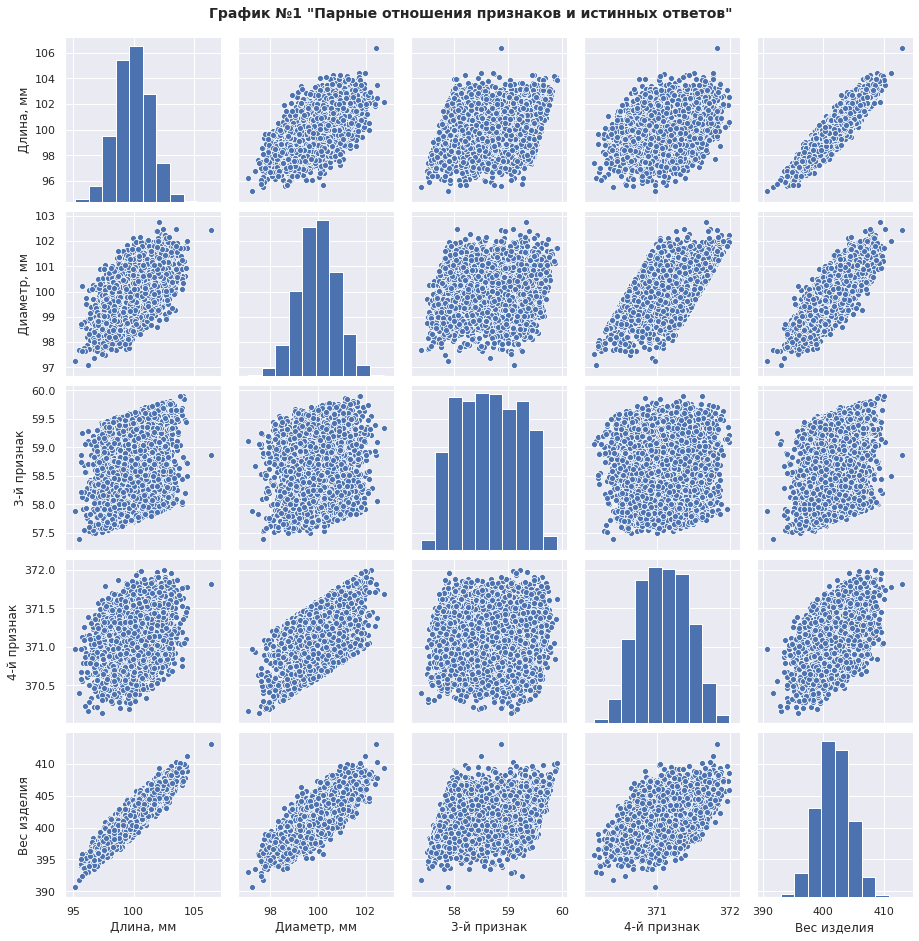

In [3]:
# print ('График №1 "Парные отношения признаков и истинных ответов"')
sns_plot = sns.pairplot(dataframe)
sns_plot.fig.suptitle('График №1 "Парные отношения признаков и истинных ответов"', 
                      y = 1.03, fontsize=14, fontweight='bold')
plt.show()

# сохраним график в файл
sns_plot.savefig('graph_1.png')

Внешне датасет удался!

На графиках, не вооруженным глазом заметно, что длина изделий существенно лучше объясняют вес изделий, чем их диаметр. А 3-й и 4-й признаки, хоть и имеют схожее распределение со значениями веса изделий, очевидно, что в них содержится много шума.

Давайте еще раз акцентируем внимание на первых двух признаках и их влиянии на целевую переменную. Построим более детализированные графики.

*Смотрим код*

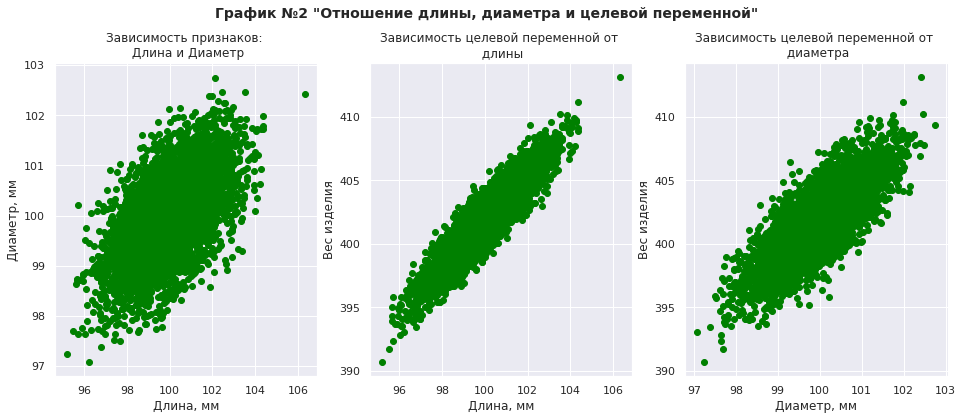

In [4]:
# формируем графики отображения зависимости признаков "Длина", "Диаметр" и целевой переменной "Вес изделия"
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 6))

fig.suptitle('График №2 "Отношение длины, диаметра и целевой переменной"', fontsize=14, fontweight='bold')
fig.subplots_adjust(top = 0.85)

ax1.scatter(dataframe['Длина, мм'],dataframe['Диаметр, мм'], color = 'green')
ax1.set_title('Зависимость признаков: \n Длина и Диаметр')
ax1.set_xlabel('Длина, мм')
ax1.set_ylabel('Диаметр, мм')

ax2.scatter(dataframe['Длина, мм'],dataframe['Вес изделия'], color = 'green')
ax2.set_title('Зависимость целевой переменной от \n длины')
ax2.set_xlabel('Длина, мм')
ax2.set_ylabel('Вес изделия')

ax3.scatter(dataframe['Диаметр, мм'],dataframe['Вес изделия'], color = 'green')
ax3.set_title('Зависимость целевой переменной от \n диаметра')
ax3.set_xlabel('Диаметр, мм')
ax3.set_ylabel('Вес изделия')

plt.show()

# сохраним график в файл
fig.savefig('graph_2.png')

Несмотря на то, что ранее, мы старательно уравновешивали влияние обоих признаков при определении значений истинных ответов, на графиках отчетливо видно, что признак длины изделий, который имеет наибольшую дисперсию, значительно лучше объясняет вес изделий. Иначе можно сказать, что длина имеет больший вес относительно диаметра в определении целевой переменной.

Конечно, нельзя считать результат этого небольшого эксперимента доказательством значимости дисперсии признака для определения целевой переменной. Однако наш пример все-таки указывает на то, что принцип максимизации дисперсии может работать при определенных условиях.

Кстати, обратим внимание на то, что диаметр изделия сильно зависит от его длины. Другими словами, зная длину изделия, мы можем с хорошей точностью, определить его диаметр. Можно, конечно, наоборот - на основании диаметра определять длину, но качество будет заметно ниже. 

А теперь вопрос! Почему бы нам, в соответствии с принципом максимизации дисперсии, просто взять и удалить признаки, имеющие наименьшую дисперсию? Зачем нам преобразовывать данные?

Спешу разочаровать, однозначного и строгого ответа со всеми сопутствующими теоретическими выкладками на данный вопрос в статье дано не будет. Однако, не спешим отчаиваться и продолжим рассмотрение нашего примера. Обучим модель линейной регрессии на исходных и преобразованных данных, затем сравним качество модели на обоих пространствах по размеру среднеквадратичной ошибки (Mean Squared Error, $MSE$). Внимательный читатель, наверное уже догадывается, что мы ожидаем увидеть лучшее качество на преобразованных данных или по крайней мере сопоставимое качество, но при использовании меньшего количества преобразованных признаков.

*Смотрим код*

In [5]:
# инициируем таблицу ошбок среднеквадратичных отклонений
table_errors_test = pd.DataFrame(index = ['MSE_test'])

# напишем функцию определения среднеквадратичной ошибки
def error(x_train, x_test, y_train, y_test):
    # инициируем модель линейной регрессии
    model = LinearRegression()
    # обучим модель на обучающей выборке
    model_fit = model.fit(x_train,y_train)
    # сформируем вектор прогнозных значений
    y_pred = model_fit.predict(x_test)
    # определим среднеквадратичную шибку
    error = round(mean_squared_error(y_test, y_pred),3)
    return error

# разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# проведем центрирование данных (функция нормирования отключена)
scaler = StandardScaler(with_mean = True, with_std = False)
scaler = scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

# инициируем модель PCA с 4 компонентами
model_pca = PCA(n_components = 4)
# обучим модель на обучающей выборке
model_pca.fit(X_train_norm)
# преобразуем данные обучающей выборки
Z_train_norm = model_pca.transform(X_train_norm)
# преобразуем данные тестовой выборки
Z_test_norm = model_pca.transform(X_test_norm)

# сформируем в pandas таблицу оценок качества модели линейной регрессии в зависимости от используемых признаков
table_errors_test['Все признаки'] = error(X_train_norm, X_test_norm, y_train, y_test)
table_errors_test['3-и признака'] = error(X_train_norm[:,0:3], X_test_norm[:,0:3],y_train, y_test)
table_errors_test['Длина + Диаметр'] = error(X_train_norm[:,0:2], X_test_norm[:,0:2],y_train, y_test)
table_errors_test['Длина'] = error(X_train_norm[:,0].reshape(-1,1), X_test_norm[:,0].reshape(-1,1),
                                   y_train, y_test)
table_errors_test['Диаметр'] = error(X_train_norm[:,1].reshape(-1,1), X_test_norm[:,1].reshape(-1,1), 
                                     y_train, y_test)
table_errors_test['Все компоненты'] = error(Z_train_norm, Z_test_norm, y_train, y_test)
table_errors_test['Три компоненты'] = error(Z_train_norm[:,0:3], Z_test_norm[:,0:3], y_train, y_test)
table_errors_test['Две компоненты'] = error(Z_train_norm[:,0:2], Z_test_norm[:,0:2], y_train, y_test)
table_errors_test['Первая компонента'] = error(Z_train_norm[:,0].reshape(-1,1), 
                                               Z_test_norm[:,0].reshape(-1,1), 
                                               y_train, y_test)


print ('Таблица №1 "Сравнение качества модели линейной регрессии, обученной на различных признаках"')
table_errors_test

Таблица №1 "Сравнение качества модели линейной регрессии, обученной на различных признаках"


,Все признаки,3-и признака,Длина + Диаметр,Длина,Диаметр,Все компоненты,Три компоненты,Две компоненты,Первая компонента
MSE_test,0.332,0.339,0.373,1.145,2.791,0.332,0.332,0.353,0.539


Результаты полностью соответствуют нашим ожиданиям!

Давайте обратим внимание на более значимые для нас результаты:

Во-первых, как мы и предположили по результатам анализа диаграмм рассеяния, длина изделий лучше объясняет их вес. Это также видно при сравнении среднеквадратичной ошибки модели линейной регрессии, обученной на значениях длины изделия со среднеквадратичной ошибкой модели, обученной на значениях диаметра. В первом случае ошибка составляет $1.145$, во втором случае - $2.791$. То есть, качество модели, обучаемой на значениях длины изделий более чем в два раза выше.

Во-вторых, модель, которая использует в расчетах только первую компоненту преобразованного пространства, показывает значительно лучшее качество, относительно модели, использующей единственный признак исходного пространства с наибольшей дисперсией - длину изделия. Качество отличается почти в два раза. То есть, при определенных условиях, метод главных компонент, может преобразовывать исходное пространство так, что первая компонента каким-то образом "впитывает" в себя информацию, которая хорошо объясняет значения целевой переменной.

В-третьих, качество модели, обученной на трех компонентах, не уступает качеству моделей, обученных как на всех четырех компонентах, так и на всех признаках. Учитывая, что наш датасет состоит из двух образующих признаков и двух производных от них признаков, в которые мы добавили значительное количество шума, то достижение качества модели при использовании трех компонент сопоставимого с качеством модели, использующей четыре компоненты, подтверждает мысль о том, что метод главных компонент действительно может позволять отсеивать шумовые значения в отдельные компоненты с наименьшей дисперсией. В нашем случае, при обучении модели линейной регрессии, компоненты с наименьшей дисперсией стоит исключить из процесса обучения.


Давайте теперь посмотрим на то, какие изменения претерпело признаковое пространство. Для этого сравним статистики обучающей выборки исходных признаков со статистиками той же выборки, но уже на преобразованном пространстве.

Для начала посмотрим на статистики, которые предоставляет нам метод *describe* библиотеки *pandas*

In [6]:
# формируем таблицу основных описательных статистик исходного пространства
X_train_dataframe = pd.DataFrame(X_train_norm)
X_train_dataframe.columns = columns_x
X_df_describe = X_train_dataframe.describe(percentiles = []).round(3)


# формируем матрицу преобразованного пространства
Z_train_norm = model_pca.transform(X_train_norm)
Z_train_dataframe = pd.DataFrame(Z_train_norm)
columns_z = ['1-я компонента','2-я компонента', '3-я компонента','4-я компонента']
Z_train_dataframe.columns = columns_z

# формируем таблицу основных описательных статистик исходного пространства
Z_df_describe = Z_train_dataframe.describe(percentiles = []).round(3)

# формируем сравнительную таблицу основных описательных статистик двух признаковых пространств
df_describe = pd.concat((X_df_describe, Z_df_describe), axis = 1)
columns_xz = columns_x + columns_z
columns_xz

print ('Таблица №2 "Сравнение значений основных описательных статистик исходного и преобразованного пространства"')
df_describe[columns_xz]

Таблица №2 "Сравнение значений основных описательных статистик исходного и преобразованного пространства"


,"Длина, мм","Диаметр, мм",3-й признак,4-й признак,1-я компонента,2-я компонента,3-я компонента,4-я компонента
count,3350.000,3350.000,3350.000,3350.000,3350.000,3350.000,3350.000,3350.000
mean,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000
std,1.424,0.810,0.561,0.341,1.528,0.631,0.547,0.286
min,-4.764,-2.904,-1.270,-0.952,-5.487,-2.074,-1.103,-0.564
50%,-0.016,-0.002,-0.007,-0.004,-0.016,0.005,-0.007,-0.005
max,6.368,2.486,1.203,0.892,6.847,2.189,1.131,0.569


Из интересующего нас, здесь стоит отметить, что после преобразования исходных признаков, первая компонента имеет больший разброс данных в отличии от исходного признака с наибольшим стандартным отклонением - длины изделий.

Давайте посмотрим на матрицы ковариаций исходных и преобразованных признаков.

In [7]:
# формируем матрицу ковариации исходных признаков
X_df_cov = X_train_dataframe.cov().round(3)

# формируем матрицу ковариации преобразованных признаков
Z_df_cov = Z_train_dataframe.cov().round(3)

# формируем сравнительную таблицу ковариаций
df_cov = pd.concat((X_df_cov, Z_df_cov), axis = 1)

print ('Таблица №3 "Сравнение матрицы ковариации исходных и преобразованных признаков"')
df_cov[columns_xz].fillna('-')

Таблица №3 "Сравнение матрицы ковариации исходных и преобразованных признаков"


,"Длина, мм","Диаметр, мм",3-й признак,4-й признак,1-я компонента,2-я компонента,3-я компонента,4-я компонента
"Длина, мм",2.028,0.675,0.159,0.155,-,-,-,-
"Диаметр, мм",0.675,0.656,0.053,0.14,-,-,-,-
3-й признак,0.159,0.053,0.314,0.014,-,-,-,-
4-й признак,0.155,0.14,0.014,0.116,-,-,-,-
1-я компонента,-,-,-,-,2.336,-0,-0,0
2-я компонента,-,-,-,-,-0,0.398,0,-0
3-я компонента,-,-,-,-,-0,0,0.299,0
4-я компонента,-,-,-,-,0,-0,0,0.082


Действительно, мы наблюдаем некое перераспределение дисперсии признакового пространства в компоненты преобразованного. 

В теории, дисперсии должны перераспределяться следующим образом. Первая компонента объясняет максимум
изменчивости исходных переменных, то есть имеет большую дисперсию, вторая – максимум оставшейся изменчивости и т.д., при этом все компоненты должны быть декоррелированны друг к другу.

В целом нечто похожее мы и наблюдаем.

Можно обратить внимание еще и на то, что после преобразования, информация с точки зрения сохранности дисперсии у нас никуда не девается - сумма дисперсий признаков исходного и преобразованного пространств полностью совпадает.

In [8]:
# сравним суммы дисперсий на исходном и преобразованном пространстве
print (round(sum(X_train_dataframe.var()), 3), '- Сумма дисперсий исходных признаков')
print (round(sum(Z_train_dataframe.var()),3), '- Сумма дисперсий преобразованных признаков')
print ()
print ('Значимость компонент:')
print (list(map(lambda x: round(x,3), model_pca.explained_variance_ratio_)))

3.114 - Сумма дисперсий исходных признаков
3.114 - Сумма дисперсий преобразованных признаков

Значимость компонент:
[0.75, 0.128, 0.096, 0.026]


Значимость компонент означает всего лишь долю дисперсии компоненты в сумме дисперсий компонент.

Кстати, заметим, что компоненты расположены в порядке убывания значений их дисперсий. Таким образом, наиболее значимые для анализа данных компоненты, всегда расположены в первых рядах.

Ранее, мы говорили о том, что преобразованное пространство полностью декоррелированно. Давайте убедимся в этом.

In [9]:
# формируем таблицу корреляции исходных признаков
X_df_cor = X_train_dataframe.corr().round(3)

# формируем таблицу корреляции преобразованных признаков
Z_df_cor = Z_train_dataframe.corr().round(3)

# формируем сравнительную таблицу корреляции
df_cor = pd.concat((X_df_cor, Z_df_cor), axis = 1)
# df_cor.fillna(0)

print ('Таблица №4 "Сравнение корреляции исходных и преобразованных признаков"')
df_cor[columns_xz].fillna('-')

Таблица №4 "Сравнение корреляции исходных и преобразованных признаков"


,"Длина, мм","Диаметр, мм",3-й признак,4-й признак,1-я компонента,2-я компонента,3-я компонента,4-я компонента
"Длина, мм",1,0.586,0.199,0.318,-,-,-,-
"Диаметр, мм",0.586,1,0.116,0.508,-,-,-,-
3-й признак,0.199,0.116,1,0.072,-,-,-,-
4-й признак,0.318,0.508,0.072,1,-,-,-,-
1-я компонента,-,-,-,-,1,-0,-0,0
2-я компонента,-,-,-,-,-0,1,0,-0
3-я компонента,-,-,-,-,-0,0,1,0
4-я компонента,-,-,-,-,0,-0,0,1


Полная декорреляция!

В завершении примера, посмотрим на графики парных отношений преобразованных признаков.

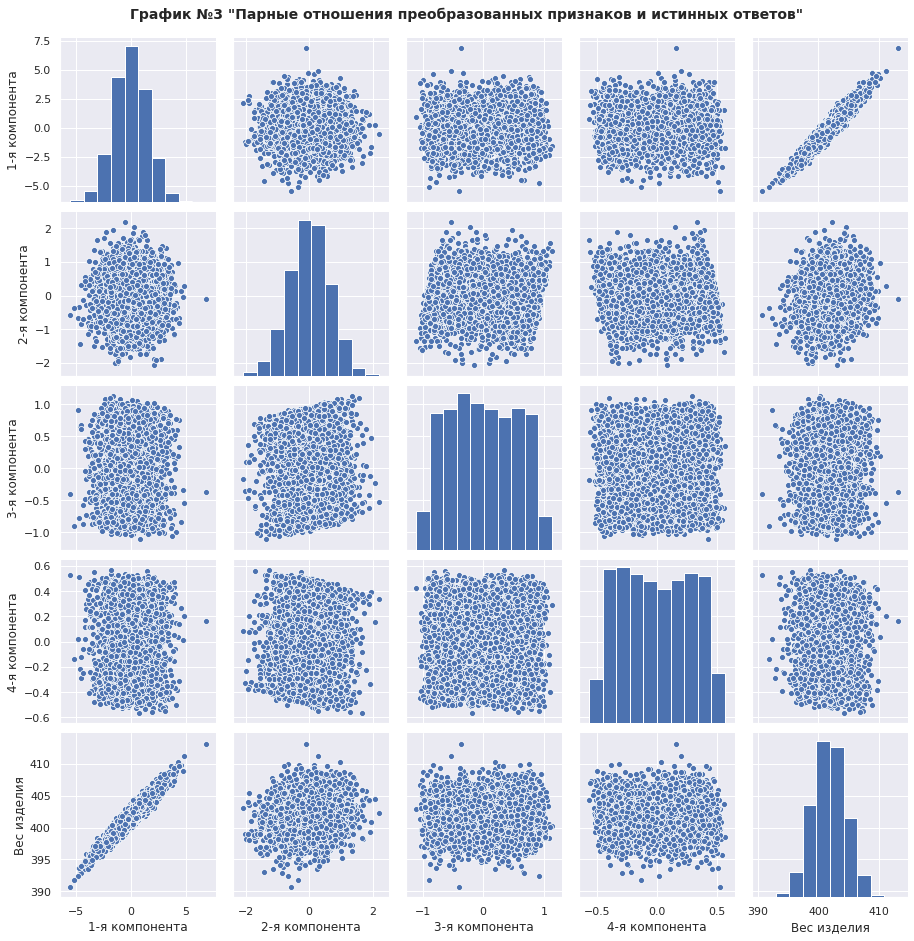

In [10]:
# print ('График №3 "Парные отношения признаков и истинных ответов"')
Z_y_train_dataframe = pd.DataFrame(np.hstack((Z_train_norm,y_train)))
Z_y_train_dataframe.columns = columns_z + ['Вес изделия']
sns_plot = sns.pairplot(Z_y_train_dataframe)
sns_plot.fig.suptitle('График №3 "Парные отношения преобразованных признаков и истинных ответов"', 
                      y = 1.03, fontsize=14, fontweight='bold')
plt.show()

# сохраним график в файл
sns_plot.savefig('graph_3.png')

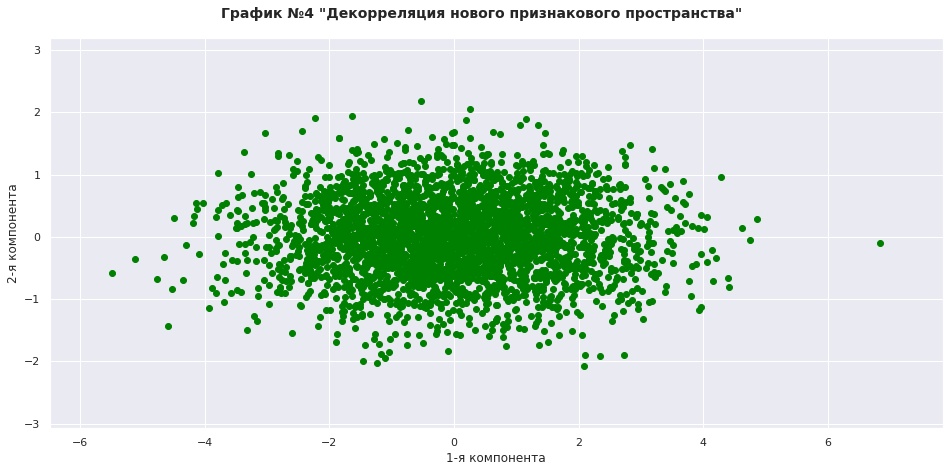

In [11]:
# print ('График №4 "Декорреляция нового признакового пространства"')
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1, aspect = 'equal')
ax.grid(True, which='both')

fig.suptitle('График №4 "Декорреляция нового признакового пространства"', fontsize=14, fontweight='bold')
fig.subplots_adjust(top = 1.05)

ax.set_ylim(np.min(Z_train_norm[:,1])-1, np.max(Z_train_norm[:,1])+1)
ax.set_xlim(np.min(Z_train_norm[:,0])-1, np.max(Z_train_norm[:,0])+1)
ax.plot(Z_train_norm[:,0], Z_train_norm[:,1], 'o', color = 'green')
plt.xlabel('1-я компонента')
plt.ylabel('2-я компонента')
plt.show()

# сохраним график в файл
fig.savefig('graph_4.png')

Итак, наш пример подошел к завершению. 

Мы воочию убедились, что метод главных компонент позволяет преобразовывать данные таким образом, что для обучения машинных алгоритмов (в нашем случае, модель линейной регрессии), можно использовать меньшее количество преобразованных признаков - компонент, относительно исходного пространства.

Это достигается за счет:

- перераспределения дисперсии, отражающей уровень информативности данных

- полной декорреляции исходного пространства

Теперь самое время залезть под капот алгоритма и понять все "волшебство" преобразований.

## 2 Под капотом алгоритма
### 2.1 Линейное преобразование исходного признакового пространства

Переходим сразу к делу. Для проведения преобразований, нам требуется умножить матрицу исходного признакового пространства $X$ на некую матрицу $W$ и получить новое признаковое пространство $Z$, такое, в котором:

- во-первых, новые признаки - компоненты декоррелированны между собой;

- во-вторых, сумма дисперсий значений компонент равняется сумме дисперсий значений исходных признаков;

- в-третьих, на главной диагонали матрицы ковариации расположены дисперсии компонент в порядке убывания от большего к меньшему.

Для выполнения вышеуказанных условий и для упрощения последующих рассчетов нам следует задать одно важно условие касательно матрицы $W$. Она должна быть ортогональна. Другими словами матрица $W$ - квадратная, $W^{-1}=W^T$, а также $W^TW=WW^T=I$, где $I$ - единичная матрица. Напомним, что единичной матрицей называют квадратную матрицу, у которой элементы главной диагонали равны единице поля, а остальные - нулю.

Запишем преобразование в матричном виде: 

$$ \begin{equation*}
 \begin{cases}
   XW = Z
   \\
   W^TW = I
 \end{cases}
\end{equation*} $$

По правилам хорошего тона укажем размерность матриц:

Матрица $X$ имеет размерность ($n$ x $m$)

Матрица $W$ - ($m$ x $m$) 

Матрица $Z$ - ($n$ x $m$)

Матрица $I$ - ($m$ x $m$)

Обратим внимание на то, что матрица $W$ в такой системе уравнений может быть только квадратной и иметь размерность ($m$ x $m$), а следовательно, и матрица $Z$ будет иметь такую же размерность как матрица $X$. Однако, если мы хотим понизить размерность, то мы должны использовать не всю матрицу $W$, а только то количество столбцов, сколько признаков в преобразованном в пространстве мы желаем получить. Но для того, чтобы использовать выборочное количество столбцов матрицы $W$, мы для начала должны вычислить ее полностью. 

Не знаю, насколько данная запись будет понятна читателю, но лично мне кажется логичной запись:

$$ \begin{equation*}
 \begin{cases}
   XW^d = Z^d
   \\
   W^{D^T}W^D = I^D
 \end{cases}
\end{equation*} $$

Понятно, что $W^d$ имеет размерность $d$, а $W^D$ - $D$, при этом если мы не желаем понижать размерность, то $d$ и $D$ будут совпадать.

Давайте, чтобы математика лучше усваивалась, будем рассматривать пример на конкретных цифрах. За основу возьмем данные из прошлого примера. Однако, для упрощения рассчетов, в датасете оставим только два признака - длина и диаметр изделия. И далее будем сами, без использования *PCA* библиотеки *sklearn* преобразовывать данные. После самостоятельных преобразований сравним результаты с преобразованиями с помощью *sklearn.

Итак, инициируем матрицу $X$.

In [12]:
np.random.seed(0)
# инициализируем математическое ожидание двух случайных величин
mu = np.array((0.,0.))
# инициализируем матрицу ковариации двух случайных величин
cov = cov
# инициализируем количество объектов
N = N
# формируем матрицу признаков с параметрами mu и cov
X = np.dot(np.random.randn(N, 2), cov) + mu
# зафиксируем матрицу признаков в таблице pandas 
X_df = pd.DataFrame(X)
columns_mini = ['Длина','Диаметр']
X_df.columns = columns_mini

Размерность матрицы $X$ составляет ($5000$ x $2$), а значит полная размерность матрицы $W$: ($2$ x $2$)

Теперь, когда мы получили систему уравнений и выяснили, что нам нужно найти матрицу $W$, нам следует ответить на вопрос - как главное уравнение связано с принципом максимизации дисперсии, да и вообще - с дисперсией? А самое важное - понять, как вычислять матрицу $W$ с учетом принципа максимизации дисперсии?

### 2.2 Связка линейного преобразования исходного признакового пространства с принципом максимизации дисперсии через матрицу ковариации $Z$

Давайте сделаем следующий трюк. Вместо поиска матрицы $Z$ будем определять матрицу ковариации $\Lambda$ матрицы $Z$, тогда:

$\Lambda = Cov(Z) = Z^TZ = (XW)^TXW = W^TX^TXW$

Для любителей более подробных математических выкладок есть еще один способ:

$\Lambda = Cov(Z) = Z^TZ = \frac{1}{N}(Z-\mu_Z)^T(Z-\mu_Z) = \frac{1}{N}(XW - \mu_XW)^T(XW - \mu_XW) = $

$ = \frac{1}{N}W^T(X-\mu_X)^T(X-\mu_X)W = \frac{1}{N}W^TX^TXW  $

Обратим внимание на некоторые отличия в подходах. Первое уравнение в виде матричной записи предполагает, что матрица $X$ предварительно была отцентрирована ($X - \mu_X$) и определенные в ходе решения уравнения десперсии как будто по умолчанию усредненны ($\frac{1}{N}$). Второе уравнение раскрывает эти моменты и предполагает необходимость проведения их в процессе решения.

Запишем получившуюся систему уравнений:

$$ \begin{equation*}
 \begin{cases}
   W^TX^TXW = \Lambda
   \\
   W^TW = I
 \end{cases}
\end{equation*} $$

Надеюсь, все уловили, что мы не просто преобразовали уравнение $XW=Z$, мы по сути изменили задачу, так как теперь вместо матрицы $Z$ мы хотим получить $Z^TZ$. 

С размерностью матриц в данной системе уравнений такая же ситуация как и в системе, указанной выше. Матрица $W$ по определению квадратная, но если мы желаем понизить размерность, то для начала мы вычисляем полную матрицу $W$, а затем берем только то количество столбцов, сколько признаков-компонент в новом пространстве мы хотим оставить.

Посмотрим на цифры из нашего примера, при условии того, что мы не хотим понижать размерность преобразованных данных. Тогда размерность матрицы $\Lambda$ составит: ($2$ x $2$) $\centerdot$ ($2$ x $5000$) $\centerdot$ ($5000$ x $2$) $\centerdot$ ($2$ x $2$) = ($2$ x $2$)

Самое время перейти к решению системы уравнений.

### 2.3 Метод множителей Лагранжа

Не будем заниматься обоснованием и доказательством метода, обозначим лишь, что данный метод является универсальным при поиске условных экстремумов. Действительно, у нас есть условие ортогональности матрицы $W$: $W^TW = I$ и есть желание найти экстремумы - значения матрицы $W$, при которых элементы главной диаганоли ковариационной матрицы $Z$ - дисперсии в преобразованном пространстве, максимальны. 

В соответствии с методом множителей Лагранжа, систему уравнений с условием можно записать как функцию Лагранжа:

$$ L = f(W) + \lambda \centerdot \varphi(W) $$

, где $f(W)$ - главное уравнение системы

$\varphi(W)$ - уравнение связи приравненное к нулю

$\lambda$ - множитель Лагранжа

Для перехода нашей системы уравнений в функцию Лагранжа:

 - Во-первых, представим матричное выражение $W^TX^TXW$ в виде функции $f(W)$, то есть $f(W) = W^TX^TXW$.

 - Во-вторых, уравнение связи об ортогональности матрицы $W$: $W^TW$ представим в виде функции $\varphi(W)$ и приравняем ее к нулю.

 - В-третьих, осуществим некоторые уточнения. С этими уточнениями можно будет подробно ознакомиться буквально через абзац. А пока смотрим на функцию Лагранжа, которая у нас получилась:

$$ L=\vec{w_j^T}X^TX\vec{w_j} - \lambda_j(\vec{w_j^T}\vec{w_j}-1) $$

В функции Лагранжа у нас не известны $\vec{w_j}$ и множитель Лагранжа - $\lambda_j$. И именно этот множитель мы будем находить в первую очередь, а после перейдем к поиску $\vec{w_j}$.

Теперь, как и было обещано, подробности об уточнениях. 

В очередной раз прибегнем к такому трюку, как к замене задачи. В этот раз мы будем определять матрицу $W$ не целиком, а по столбцам, то есть для начала, как будто, будем искать каждый ее столбец и после того как определим все столбцы, то соберем и матрицу целиком. Другими словами, мы представляем матрицу $W$ как совокупность векторов $\vec{w_j}$, и следовательно матрицу $\Lambda$ представим как совокупность $\lambda_j$. Запишем эти изменения:

$$ \begin{equation*}
 \begin{cases}
   W^TX^TXW = \Lambda
   \\
   W^TW = I
 \end{cases}
\mkern 15mu \Longrightarrow \mkern 20mu 
 \begin{cases}
   \vec{w_j^T}X^TX\vec{w_j} = \lambda_j
   \\
   \vec{w_j^T}\vec{w_j} = 1
 \end{cases}
\end{equation*} 
$$

Такая запись задачи дает нам удобство в дальнейших рассчетах. Ведь раннее нам требовалось для приравнивания $\varphi(W)$ к нулю вычислять $(I - W^TW)$. Использование единичной матрицы $I$ в расчетах не очень удобно. В результате такого изменения задачи, нам потребуется использовать вместо единичной матрицы в расчетах простое число - единицу, а значит $\varphi(W) =1 - \vec{w^T_j} \vec{w_j} = 0$

Запишем размерность главного выражения для каждого $j$-го случая в нашем примере: ($1$ x $2$) $\centerdot$ ($2$ x $5000$) $\centerdot$ ($5000$ x $2$) $\centerdot$ ($2$ x $1$) = $const$. То есть $\lambda_j$ это $const$, какое-то конкретное число. Интутивно мы понимаем, что $\lambda_j$ - это дисперсия или $j$-ый элемент главной диагонали ковариационной матрицы $\Lambda$. В том, что $\lambda_j$ - это $j$-ая дисперсия матрицы $\Lambda$ в статье мы доказывать не будем, но будьте уверены - интуиция нас не подводит.

Давайте, подумаем, что мы будем делать с функцией Лагранжа? 

$ L=\vec{w_j^T}X^TX\vec{w_j} - \lambda_j(\vec{w_j^T}\vec{w_j}-1) $

Верно - мы будем ее дифференцировать по $\vec{w_j}$.

### 2.4 Переход от задачи  дифференцирования функции Лагранжа по вектору $\vec{w_j}$ к задаче поиска собственных значений $ \lambda_j $ и собственных векторов $\vec{w_j}$ матрицы $X^TX$

Опустим подробности матричного дифференцирования за рамки статьи и перейдем сразу же к результату:

$$\frac{dL}{d\vec{w_j}} \mkern 5mu = \mkern 5mu \frac{(\vec{w_j^T}X^TX\vec{w_j} - \lambda_j(\vec{w_j^T}\vec{w_j}-1))'}{(\vec{w_j})'} \mkern 5mu = \mkern 5mu 2X^TX\vec{w_j} - 2\lambda_j\vec{w_j} $$

Приравняем производную к нулю:
$$ 2X^TX\vec{w_j} - 2\lambda_j\vec{w_j} = 0 \mkern 15mu \Longrightarrow \mkern 20mu  X^TX\vec{w_j} = \lambda_j\vec{w_j} $$

Таким образом, у нас возникла ситуация, когда квадратная матрица $X^TX$, умноженная на вектор $\vec{w_j}$ преобразовалась во всё тот же вектор $\vec{w_j}$, только дополнительно он еще и умноженный на некую константу $\lambda_j$. Из курса высшей математики, мы знаем, что при умножении некоторой квадратной матрицы на ненулевой вектор получается все тот же не нулевой вектор с некоторым коэффициентом, то такой вектор называется собственным вектором данной матрицы, а коэффициент - собственным числом матрицы. 

В очередной раз в этой статье мы уточняем задачу. В этот раз вместо поиска векторов $\vec{w_j}$ и чисел $\lambda_j$ нам предстоить искать собственные вектора $\vec{w_j}$ и собственные числа $\lambda_j$ матрицы $X^TX$.

### 2.5 Аналитическое решение: поиск собственных значений и собственных векторов матрицы $X^TX$

Итак, мы имеем выражение $ X^TX\vec{w_j} = \lambda_j\vec{w_j} $, в нем нам нужно найти собственные вектора $\vec{w_j}$ и собственные числа $\lambda_j$ матрицы $X^TX$


Давайте определим матрицу $X^TX$ для нашего частного случая

In [13]:
print ('Таблица №5 "Матрица X^TX"')
# рассчитаем матрицу ковариации X и запишем результат в таблицу pandas
X_df_cov = pd.DataFrame(np.dot(X.T,X)/(N), index = columns_mini)
X_df_cov.columns = columns_mini
X_df_cov.round(4)

Таблица №5 "Матрица X^TX"


,Длина,Диаметр
Длина,2.0033,0.6496
Диаметр,0.6496,0.6394


Раскроем выражение $X^TXw_j = \lambda_jw_j$:

$$ X^TXw_j = \lambda_jw_j \mkern 10mu \Longrightarrow \mkern 10mu \begin{pmatrix} 2.0033 & 0.6496 \\ 0.6496 & 0.6394 \end{pmatrix} \centerdot \begin{pmatrix} w_{1j} \\ w_{2j} \end{pmatrix} = \lambda_j \centerdot \begin{pmatrix} w_{1j} \\ w_{2j} \end{pmatrix} \qquad $$

#### В первую очередь определяем собственные числа матрицы $X^TX$

Выполним алгебраические действия - умножим матрицу на вектор:

$$ \begin{pmatrix} 2.0033 w_{1j} + 0.6496 w_{2j} \\ 0.6496 w_{1j} + 0.6394 w_{2j} \end{pmatrix} = \begin{pmatrix} \lambda_j w_{1j} \\ \lambda_j w_{2j} \end{pmatrix} \qquad $$

Приравняем соответствующие элементы векторов-столбцов и получим однородную систему линейных уравнений:

$$ \begin{equation*}
 \begin{cases}
   2.0033 w_{1j} + 0.6496 w_{2j} = \lambda_j w_{1j}
   \\
   0.6496 w_{1j} + 0.6394 w_{2j} = \lambda_j w_{2j}
 \end{cases}
\mkern 15mu \Longrightarrow \mkern 20mu 
 \begin{cases}
   2.0033 w_{1j} + 0.6496 w_{2j} - \lambda_j w_{1j} = 0
   \\
   0.6496 w_{1j} + 0.6394 w_{2j} - \lambda_j w_{2j} = 0
 \end{cases}
\end{equation*} 
$$

Сделаем ход конем: в верхнем уравнении вынесем за скобку $w_{1j}$, во втором - $w_{2j}$:

$$ \begin{equation*}
  \begin{cases}
   (2.0033 - \lambda_j)w_{1j} + 0.6496 w_{2j} = 0
   \\
   0.6496 w_{1j} + (0.6394 - \lambda_j) w_{2j} = 0
 \end{cases}
\end{equation*} 
$$

По определению собственный вектор $\vec{w_j}$ не может быть нулевым, то есть $w_{1j} \neq w_{2j} \neq 0$. Из этого следует, что уравнения линейно зависимы и тогда определитель матрицы системы равен нулю:

$$
\left|
  \begin{array}{}
     2.0033 - \lambda_j & 0.6496 \\
     0.6496 & 0.6394 - \lambda_j \\
  \end{array}
\right|
= 0$$

Раскроем определитель и решим квадратное уравнение:

$(2.0033-\lambda_j)(0.6394 - \lambda_j) -0.6496 \centerdot 0.6496 = 0$

$\lambda^2_j - 2.6427\lambda_j + 0.8589 = 0$

$D = 3.5483$, $\sqrt{D} \approx 1.8837$


$\lambda_{1} = 2.2632$, $\lambda_{2} = 0.3795$

Половина дела завершена - мы нашли собственные значения матрицы $X^TX$. Раннее, мы делали интуитивное предположение, что собственные значения матрицы $X^TX$, это не что иное как дисперсии преобразованного признакового пространства. Тогда, с учетом того, что метод главных компонент сохраняет дисперсию исходного пространства в преобразованном пространстве, мы можем сверить сумму собственных значений (равно сумму дисперсий преобразованного пространства) с суммой дисперсий исходного пространства. Мы ожидаем увидеть знак равенства между этими величинами.

Сумма дисперсий в исходном признаковом пространстве составляет: $2.0033 + 0.6394 = 2.6427$.

Сумма дисперсий в преобразованном пространстве: $2.2632 + 0.3795 = 2.6427$

Суммы совпадают, а значит мы на верном пути. Переходим к поиску собственных векторов $\vec{w_j}$.

#### Определяем собственные вектора матрицы $X^TX$

Для определения собственных векторов нам надо по очереди в систему уравнений, приведенную ниже, подставить, полученные значения $\lambda$: $2.2632$ и $0.3795$:

$$ \begin{equation*}
  \begin{cases}
   (2.0033 - \lambda_j)w_{1j} + 0.6496 w_{2j} = 0
   \\
   0.6496 w_{1j} + (0.6394 - \lambda_j) w_{2j} = 0
 \end{cases}
\end{equation*} 
$$

Определим собственный вектор $\vec{w_j}$, соответствующий собственному числу $\lambda_{1} = 2.2632$:

$ \begin{equation*}
  \begin{cases}
   -0.2599w_{11} + 0.6496 w_{21} = 0
   \\
   0.6496 w_{11}  - 1.6238w_{21} = 0
 \end{cases}
\end{equation*} 
$

Казалось, бы выразим $w_{1j}$ через $w_{2j}$ и дело в шляпе, но нас подстерегают очередные сюрпризы. Смотрим:

$ \begin{equation*}
  \begin{cases}
   w_{11} = 2.4996w_{21}
   \\
   1.6238 w_{11}  - 1.6238w_{21} = 0
 \end{cases}
\end{equation*} 
$

Такая система уравнений имеет бесконечное множество решений, но главное здесь - соотношение между искомыми значениями $w_{1j}$ и $w_{2j}$. Оно должно составлять 2.4996. Хорошо, давайте тогда выберем пару значений:

$ \begin{equation*}
  \begin{cases}
   w_{11} = 2.4996
   \\
   w_{21}  = 1.0000
 \end{cases}
\end{equation*} 
$

Таким же образом, определим собственный вектор, соответствующий собственному числу $\lambda_{2} = 0.3795$. Не будем подробно расписывать решение, приведем результат:

$ \begin{equation*}
  \begin{cases}
   w_{12} = -0.4000
   \\
   w_{22}  = 1.0000
 \end{cases}
\end{equation*} 
$

В итоге, мы получили матрицу $W$, состоящую из собственных векторов. 

$$ W = \begin{pmatrix} 2.4996 & -0.4000 \\ 1.0000 & 1.0000 \end{pmatrix} \qquad $$

Однако, это еще не совсем та матрица, которую мы искали. В ней могли быть совсем другие значения, конечно же с условием сохранения соотношений между $w_{1j}$ и $w_{2j}$. Так какую нам выбрать матрицу, какие значения в конечном итоге подставить? Ответ - выбираем нормированную матрицу. Опустим подробности рассуждения, почему нам требуется нормировка матрицы, упомянем лишь о том, что без нормирования матрицы $W$ не будет возможно выполнить условие ортогональности матрицы.

Для нормировки матрицы $W$, воспользуемся имеющейся в библиотеке *numpy* функцией *linalg.norm()*. Выберем настройки по умолчанию. Это будет норма Фробениуса.

In [14]:
W = np.array(([2.4996, -0.4],[1., 1.]))

def normalize(w):
    norm = np.linalg.norm(w, axis = 0)
    return w / norm

W_norm = normalize(W).round(4)
W_norm

array([[ 0.9285, -0.3714],
       [ 0.3714,  0.9285]])

В итоге мы получили следующую матрицу:

$$ W_{norm} = \begin{pmatrix} 0.9285 & -0.3714 \\ 0.3714 & 0.9285 \end{pmatrix} \qquad $$

Давайте осуществим проверку на выполнение требования ортогональности матрицы $W$: $W^TW = I$. Для этого воспользуемся функцией *dot* из библиотеки *numpy*

In [15]:
print ('Проверка матрицы W на ортогональность: \n', np.dot(W_norm.T,W_norm).round(2))

Проверка матрицы W на ортогональность: 
 [[ 1. -0.]
 [-0.  1.]]


Действительно, мы получили единичную матрицу. Проверка пройдена. Запишем результаты.

Собственные значения матрицы $X^TX$: 

$\lambda_{1} = 2.2632$, $\lambda_{2} = 0.3795$

Матрица собственных векторов: 

$ W = \begin{pmatrix} 0.9285 & -0.3714 \\ 0.3714 & 0.9285 \end{pmatrix} \qquad $

Заметьте, если наша задача преобразовать пространство с понижением размерности, то в нашем случае мы будем умножать матрицу $X$ на первый столбец матрицы $W = \begin{pmatrix} 0.9285 \\ 0.3714 \end{pmatrix}$, так как он соответствует наибольшему собственному значению матрицы $X^TX$ (иначе дисперсии матрицы $Z$) $\lambda_{1} = 2.2632$.

Для определения собственных значений и векторов матрицы $X^TX$ в библиотеке $numpy$ предусмотрена функция $linalg.eig()$. Сравним результаты.

In [16]:
v, W = np.linalg.eig(X_df_cov)

print ('Собственные значения: \n', v.round(4))
print ()
print ('Матрица собственных векторов: \n', W.round(4))

Собственные значения: 
 [2.2632 0.3795]

Матрица собственных векторов: 
 [[ 0.9285 -0.3715]
 [ 0.3715  0.9285]]


Результаты сошлись. На этой мажорной ноте мы завершаем изучение математики процесса в методе главных компонент.

## Вспомогательные материалы

### 1. Литература

1.1 Многомерный статистический анализ и временные ряды, Том 3, Кендалл М., Стюарт А., Москва, "Наука", 1976

1.2 Введение в теорию матриц, Р.Беллман, Москва, "Наука", 1969

1.3 Python для сложных задач, Дж.Вандер Плас, "Питер", 2018

### 2. Лекции, курсы (видео)

2.1 [Курс "Поиск структуры в данных" специализации "Машинное обучение и анализ данных", МФТИ, ЯНДЕКС](https://www.coursera.org/learn/unsupervised-learning/)

2.2 [Лекция "Метод главных компонент", НИУ ВШЭ, 2016](http://math-info.hse.ru/f/2015-16/ling-mag-quant/lecture-pca.html)

2.3 [Лекция "Наилучшее приближение матрицы матрицами меньшего ранга", В.Н. Малозёмов, 2014](https://www.youtube.com/watch?v=O9VK8bSp-eM)

2.4 [Лекция 9 "Факторный анализ и метод главных компонент", В.Л. Аббакумов, 2018](https://www.youtube.com/watch?v=q6BFIg2M3LE)

### 3. Интернет источники

3.1 [Статья "Как работает метод главных компонент (PCA) на простом примере", Хабр, 2016](https://habr.com/ru/post/304214/)

3.2 ["Условные экстремумы и метод множителей Лагранжа", mathprofi](http://mathprofi.ru/uslovnye_extremumy.html)

3.3 ["Собственные значения (числа) и собственные векторы", mathprofi](http://mathprofi.ru/sobstvennye_znachenija_i_sobstvennye_vektory.html)

3.4 ["Метод главных компонент (Principal component analysis)", wiki.loginom](https://wiki.loginom.ru/articles/principal-component-analysis.html)

3.5 ["Метод главных компонент (PCA)", craftappmobile, 2019](https://craftappmobile.com/%D0%BC%D0%B5%D1%82%D0%BE%D0%B4-%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85-%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82-pca/)

3.6 [Статья "Приводим уравнение линейной регрессии в матричный вид", Хабр, 2019](https://habr.com/ru/post/479398/)